In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score 

plt.style.use('fivethirtyeight')

# Regularized Regression 

## Objectives

By the end of the day you should be able to

 * State the purpose of Lasso and Ridge regression and define its loss function
 * Choose the regularization hyper-parameter with cross validation
 * Interpret results from Lasso and Ridge regression. 

## Review:  Linear Regression and Machine Learning 

1. What is the assumed relationship between features and targets in a linear regression model?  
2. What is Cross Validation?
3. What is a loss function? What is the loss function for linear regression?
4. What is the bias-variance trade off in machine learning?  
5. Can we over fit with Linear Regression? 


<br><br><br><br>
**Three themes that will continue to pop-up in new machine learning methods are:**

1. Cost/Loss/Objective Functions: RSS for Linear Regression

<!-- ![](cost.png) -->

2. Assumed functional form of a model : $\hat{y}=\beta_0 + \beta_1 x_{1} + \beta_2 x_{2} + \beta_3 x_{3}+ ...$
3. Dealing with Bias Variance Trade off 

### What will we cover in this lecture?

We will deal with high variance linear regression models by changing the loss function.  This process is referred to as **regularization.** 

### Bias-variance trade off with Linear Regression

To get started let's create a model with linear regression to over fit our data. To do this I will try to fit a model to data by using various degrees of polynomial transformation (1,3, and up to 30 degree polynomials).  

However, the data will be generated via the following process:

$$f(x) = x^{3} - 2 x^{2} + noise$$

In [2]:
# create data -- polynomial 
x_ex1 = np.linspace(-2,3,100)
y_ex1 = (x_ex1**3) - 2*(x_ex1**2) + 2*np.random.normal(size=len(x_ex1))

# create testing data as well...
x_ex1_test = np.random.uniform(-2,3,100)
y_ex1_test = (x_ex1_test**3) -2*(x_ex1_test**2) + 2*np.random.normal(size=len(x_ex1_test))

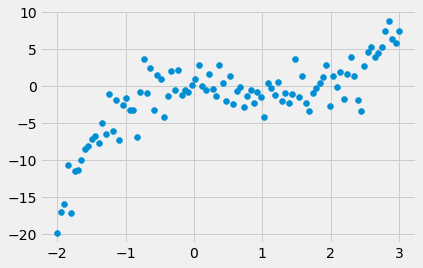

In [3]:
# plot data 
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1);

Build three models where the features are polynomial transformations up to degree n of x:

$$f(x)=\beta_0 + \beta_1 x + \beta_2 x^{2} + \beta_3 x^{3} + ... + \beta_3 x^{n}$$

In [4]:
# Build three models of different degrees of polynomials

# Handy feature in sklearn that will automatically create polynomial data 
x3 = PolynomialFeatures(3).fit_transform(x_ex1.reshape(len(x_ex1),-1))[:,1:]
x30 = PolynomialFeatures(30).fit_transform(x_ex1.reshape(len(x_ex1),-1))[:,1:]
x30_test = PolynomialFeatures(30).fit_transform(x_ex1_test.reshape(len(x_ex1_test),-1))[:,1:]
print(x3[:5])

[[-2.          4.         -8.        ]
 [-1.94949495  3.80053056 -7.40911513]
 [-1.8989899   3.60616264 -6.84806642]
 [-1.84848485  3.41689624 -6.31608092]
 [-1.7979798   3.23273135 -5.81238567]]


In [5]:
# Create three models for various polynomial transformations
model = LinearRegression().fit(x_ex1.reshape(len(x_ex1),-1), y_ex1)
model3 = LinearRegression().fit(x3, y_ex1)
model30 = LinearRegression().fit(x30, y_ex1);

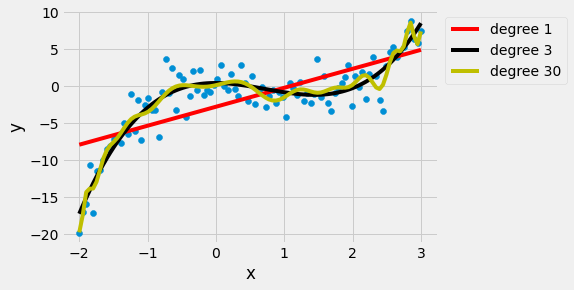

In [6]:
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model.predict(x_ex1.reshape(len(x_ex1),-1)),c='r',label='degree 1')
ax.plot(x_ex1,model3.predict(x3),c='k',label='degree 3')
ax.plot(x_ex1,model30.predict(x30),c='y',label='degree 30')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

Wouldn't it be great if we could some how change the our loss function to discourage over-fitting? 

That's exactly the goal of **regularized regression**.

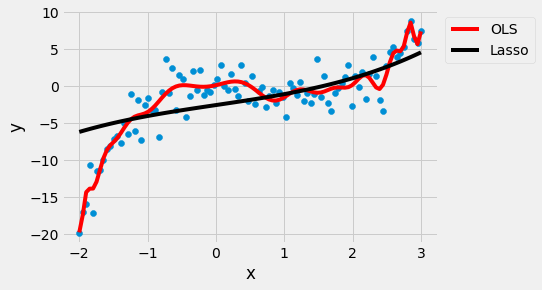

In [7]:
# build ridge model 
model_lasso30 = Lasso(alpha=0.1,  normalize=True)  # change alpha to see how model changes
model_lasso30.fit(x30, y_ex1);

fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),c='r',label='OLS')
ax.plot(x_ex1,model_lasso30.predict(x30),c='k',label='Lasso')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

## Combating Over-fitting: Introduction to Ridge and Lasso Regression
Ridge and Lasso Regression are tools to combat over-fitting...

In recent days we've talked about linear regression, in which we find the coefficients $\beta_0$, $\beta_1$, ..., $\beta_p$ to minimize

$$RSS = \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2$$

### Ridge Regression
In **Ridge Regression** we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$

Effectively we've penalizing extreme values of $\beta$ (note that we aren't including $\beta_0$). The value $\alpha$ is a hyper-parameter of the model specifying how large the penalty should be.  

Note: $\alpha \sum_{j=1}^{p} \beta_j^2$ is often referred to as the **L2 regularization penalty**.

**Question:** What does this mean if $\alpha = 0$?

**Question:** What does this mean if $\alpha \to \infty$

**Question:** How should we decide the appropriate value for $\alpha$?


### Lasso Regression 

In **LASSO Regession** (**L**east **A**bsolute **S**hrinkage and **S**election **O**perator) we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right)\right)^2 + \alpha \sum_{j=1}^{p} | \beta_j |$$

In many ways this is similar to Ridge:
  * We're penalizing large values of $\beta$.
  * We aren't including $\beta_0$.
  * We have a hyperparameter $\alpha$.

The difference is the exponent. Ridge is sometimes known as **L2 regularization**, while LASSO is **L1 regularization**. 


**Questions:** 

1. How does this relate to the bias-variance trade-off? If $\alpha$ increases, what happens to the bias? What happens to the variance?

## Visualizing the Loss Function 

### 1D Example

To illustrate this, lets actually plot the loss function for a simple model.  Let's say we build a model where we only need to find one hyper-parameter.  That is, we assume the y-intercept of a line is 0 and we need to find the slope, $\beta$.  The assumed functional form will be, 

$$f(x)=\beta x$$.

Our loss function for OLS becomes, 

$$RSS = \sum_{i=1}^n ( y_i -  \beta x_{i} )^2$$

and the loss function for Ridge and Lasso becomes, 

Ridge:
$$ \text{Loss}_{\text{Ridge}}(\beta) = \alpha \beta^2 + \sum_{i=1}^n ( y_i - \beta x_{i} ) )^2 $$

Lasso:
$$ \text{Loss}_{\text{Lasso}}(\beta) = \alpha  |\beta | + \sum_{i=1}^n ( y_i - \beta x_{i}) $$

Ok, given the data some data let's plot our loss function.  Note the RP below refers to the Regularization Penalty ($\alpha \beta^2$ or $\alpha  |\beta |$ ) and RSS refers the residual sum of squares.

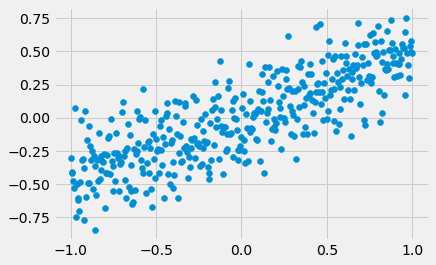

In [8]:
# get data with linear relationship plus noise
x = np.linspace(-1,1,400)
y = 0.5*x + 0.2*np.random.normal(size=len(x))

fig,ax = plt.subplots()
ax.scatter(x,y);

In [9]:
# Functions for plotting loss functions
def plot_rp(ax, alpha, loss='Ridge'):
    '''
    plots regularization penalty for ridge and lasso 
    '''
    if loss == 'Ridge':
        ax.plot(b,alpha*np.power(b,2), c='r')
    else:
        ax.plot(b,alpha*np.abs(b), c='r')
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("Regularization Penalty (RP)")
    ax.set_title("{} RP".format(loss))

def plot_rss(ax):
    '''
    plots RSS loss, and minima of loss function 
    
    returns index of minima so that this point can be plotted on ridge and lasso loss function
    '''
    loss_val = [np.dot(y - bs*x,y - bs*x) for bs in b] # get array of loss function values
    ax.plot(b, loss_val, c='b')
    ax.scatter(b[np.argmin(loss_val)],np.amin(loss_val),c='b',s=100) # plot minima of loss function
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("OLS Loss Function")
    ax.set_title("RSS Loss")
    return np.argmin(loss_val)
     
def plot_ridge_lasso(ax, alpha, index=None, show_minima=True, loss='Ridge',color='k'):
    '''
    plots ridge/lasso loss versus beta and the minima of ridge/lasso and OLS loss function 
    
    Parameters
    ----------
    alpha: alpha parameter for tradoff of RP and RSS
    index: index for array b representing minima from OLS; if None this point will not be plotted
    show_minima: only plots minima of ridge/lasso if True
    loss: Ridge or Lasso 
    '''
    if loss == 'Ridge':
        loss_val = [np.dot(y - bs*x,y - bs*x)+alpha*bs**2 for bs in b]
        ax.plot(b,loss_val, c=color, label='α={}'.format(alpha),zorder=1)
    else:
        loss_val = [np.dot(y - bs*x,y - bs*x)+alpha*np.absolute(bs) for bs in b]
        ax.plot(b,loss_val, c=color, label='α={}'.format(alpha),zorder=1)
    if index != None:  # plot OLS minima only if index given
        ax.scatter(b[index],loss_val[index],c='b',s=100,zorder=2,label='OLS solution')
    xmin,ymin = b[np.argmin(loss_val)],np.amin(loss_val)
    if show_minima:
        ax.scatter(xmin,ymin,c='k',s=100,label='Regularization solution'.format(loss))
    ax.set_xlabel("$\\beta$")
    ax.set_ylabel("{} Loss Function".format(loss))
    ax.set_title("{}".format(loss))

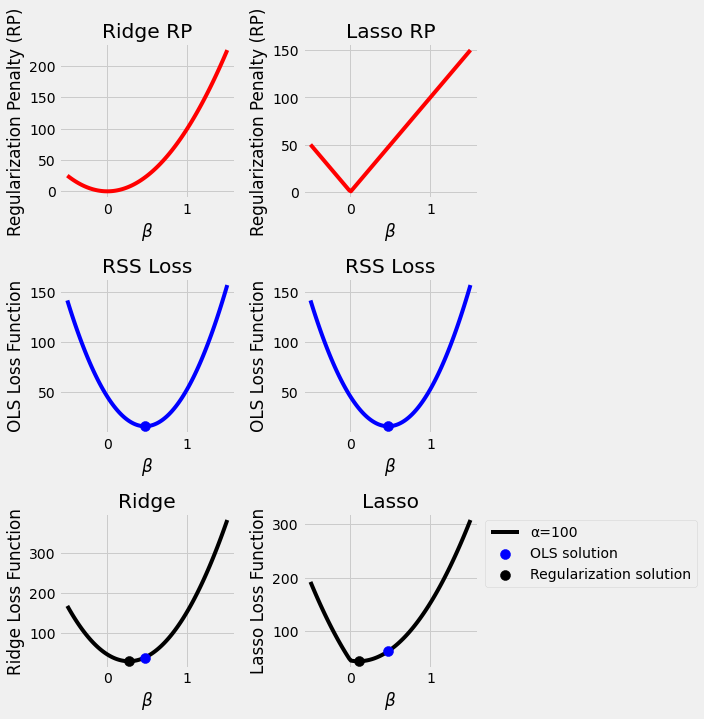

In [10]:
# variables for plotting loss functions
alpha = 100
b = np.linspace(-0.5,1.5,100)

# plotting components of loss functions
fig,axs = plt.subplots(3,2,figsize=(10,10))
# plots for ridge loss
plot_rp(axs[0,0],alpha,loss='Ridge')
index = plot_rss(axs[1,0])
plot_ridge_lasso(axs[2,0], alpha, index=index, loss='Ridge')

# plots for ridge loss
plot_rp(axs[0,1], alpha, loss='Lasso')
index = plot_rss(axs[1,1])
plot_ridge_lasso(axs[2,1], alpha, index=index, loss='Lasso')
axs[2,1].legend(loc='upper left',bbox_to_anchor=(1,1)) # plot legend for lasso only

fig.tight_layout()

### Varying Alpha

First lets take the 1D example from earlier and visually vary alpha to see what happens

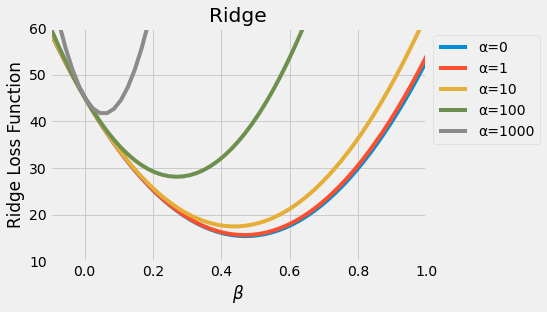

In [11]:
alpha_array = [0,1,10,100,1000]
fig,ax = plt.subplots()
for i,alpha in enumerate(alpha_array):
    plot_ridge_lasso(ax, alpha, index=None,loss='Ridge',show_minima=False,color=None)  
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlim([-0.1,1.0])
ax.set_ylim([10,60]);

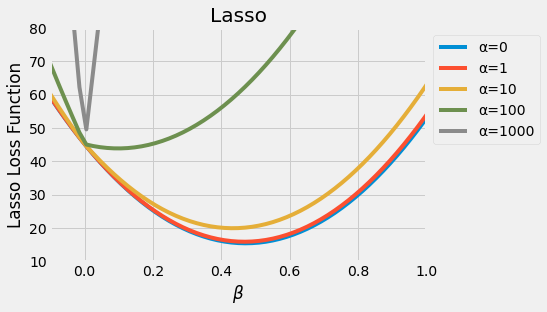

In [12]:
alpha_array = [0,1,10,100,1000]
fig,ax = plt.subplots()
for i,alpha in enumerate(alpha_array):
    plot_ridge_lasso(ax, alpha, index=None,loss='Lasso',show_minima=False,color=None)  
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlim([-0.1,1.0])
ax.set_ylim([10,80]);

### How to select alpha? A high dimensional example

Ok, so alpha will push the ideal coefficient towards zero.  But this really doesn't help us in the 1D case where we only need to find the slope of a line. 

Let's start with the polynomial example from the start of this lecture and see how alpha effects our coefficients.  We will start by plotting our over-fit OLS model as reminder:

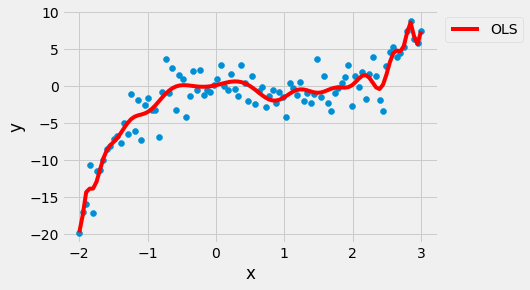

In [13]:
fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),c='r',label='OLS')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

Next, lets build various Lasso models where we consider multiple values of $\alpha$.  We will then compare both the score of these models on test data via RMSE as well as how the beta coefficient for various features vary.  

**Question** 

1. In order to compare the magnitude of our beta coefficients directly, what must we do to our data?  
2. Why else would this be important?

In [14]:
# notice normalize flag -- this will automatically standardize our data for us
model_lasso30 = Lasso(alpha=0.1,  normalize=True)  
model_lasso30.fit(x30, y_ex1);

In [15]:
def get_ridge_lasso_coeff(x,y,min_alpha_exp, max_alpha_exp, reg='Lasso',cv=True):
    '''
    builds multiple ridge or lasso models for 50 values of alpha between 
    10^(min_alpha_exp) to 10^(max_alpha_exp)
    
    Returns array of alphas and cooresponding coefficient for each feature
    '''
    nalphas = 50
    nfeatures = len(x[0])
    coefs = np.zeros((nalphas, nfeatures))
    scores = np.zeros(nalphas)
    alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
    for i, alpha in enumerate(alphas):
        if reg == 'Lasso':
            model = Lasso(alpha=alpha,normalize=True,max_iter=2000000)
        else:
            model = Ridge(alpha=alpha,normalize=True,max_iter=20000)
        model.fit(x, y)
        if cv:
            scores[i] = (np.sqrt(-1*
                         cross_val_score(model, x, y, 
                                        scoring= 'neg_mean_squared_error',
                                        cv=5))).mean()
        else:
            # Note the test data used for scoring is specific to the polynomial degree 30 data
            scores[i] =np.sqrt(np.sum((model.predict(x30_test) - y_ex1_test)**2)) #model.score(x30_test,y_ex1_test)
        coefs[i] = model.coef_
    return alphas, coefs, scores

In [16]:
def plot_alpha_v_coef(ax, alphas, coefs, column_names, method='Lasso'):
    '''
    plots alpha versus the beta coefficients 
    '''
    for feature in range(len(coefs[0])):
        if np.absolute(coefs[0,feature]) > 0.05 or feature == 2:  # only plot large coefficients + 3 order
            ax.plot(alphas, coefs[:, feature],
                     label="$\\beta_{{{}}}$".format(column_names[feature]))  #'{} order'.format(feature+1))
    ax.set_xscale('log')
    ax.set_title("$\\beta$ as a function of $\\alpha$ for {} regression".format(method))
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$\\beta$")
    ax.legend(loc="upper left",bbox_to_anchor=(1,1))

def plot_alpha_v_scores(ax, alphas, scores):
    '''
    plots alpha versus the RMSE
    '''
    ax.plot(alphas,scores,c='k')
    ax.scatter(alphas[np.argmin(scores)],scores.min(), c='k', s=100)
    print('The best RMSE is {}'.format( scores.min() ))
    ax.set_title('Model score as a function of $\\alpha$')
    ax.set_xscale('log')
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel('RMSE');    #'$R^{2}$');

The best RMSE is 23.30901016509648


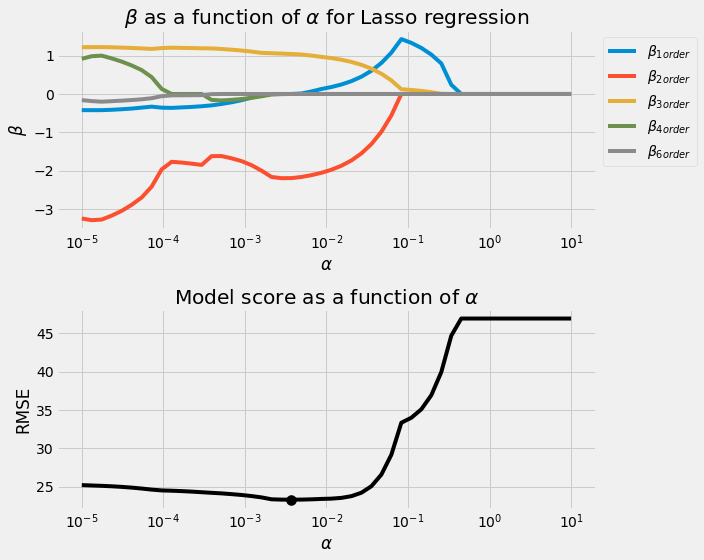

In [17]:
# create column names
column_names = ['{} order'.format(i)  for i in range(1,31) ]

# build models for various values of alpha 
alphas, coefs, scores = get_ridge_lasso_coeff(x30,y_ex1,-5,1 ,reg='Lasso',cv=False)

# plot data 
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, column_names, method='Lasso')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

The best RMSE is 24.327722856545762


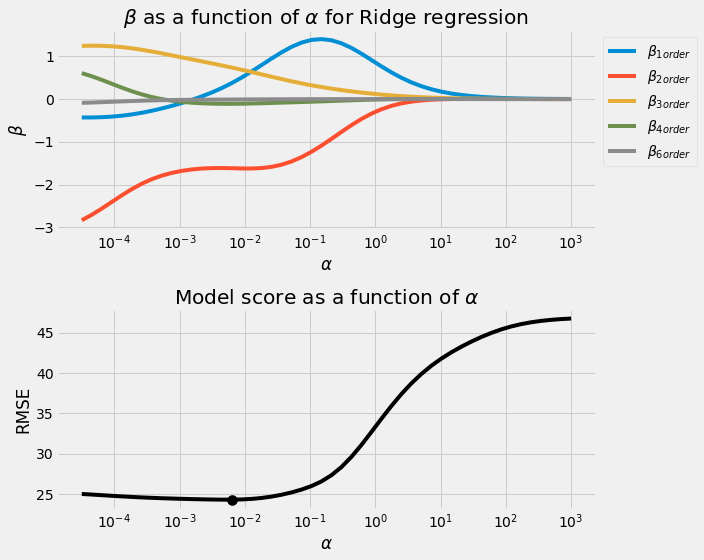

In [18]:
alphas, coefs, scores = get_ridge_lasso_coeff(x30,y_ex1,-4.5,3, reg='Ridge',cv=False)
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, column_names, method='Ridge')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

**Discussion:** What's going on?

<br><br><br><br><br><br><br><br>

Above I am plotting the $\beta$ coefficients for multiple degrees of a 30 degree polynomial.  I am plotting the coefficients that were larger than 0.01 at the smallest value of $\alpha$.  

Here we notice that as $\alpha$ increases the coefficients all go to zero.  Interestingly, the coefficients do not go to zero at the same pace.  In th case of Lasso, the 2 and 3 order polynomial data are the most important for fitting this data.  This fits perfectly with the functional form of the polynomial were used to create the data: $f(x)= x^3 -2 x^2 +noise$.  In the case of ridge, it is using more features to fit its ideal model which is a feature of ridge regression.  

Lastly, lets see how the models at various values of $\alpha$ perform. 

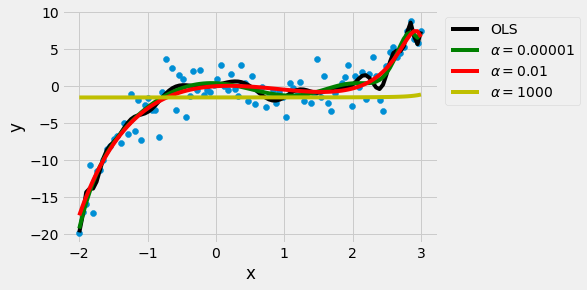

In [19]:
# fit three models with 
model_alpha_0001 = Ridge(alpha=0.00001,  normalize=True).fit(x30, y_ex1)  
model_alpha_01 = Ridge(alpha=0.01,  normalize=True).fit(x30, y_ex1) 
model_alpha_1000 = Ridge(alpha=1000,  normalize=True).fit(x30, y_ex1)  


fig,ax = plt.subplots()
ax.scatter(x_ex1,y_ex1)
ax.plot(x_ex1,model30.predict(x30),label='OLS',c='k')
ax.plot(x_ex1,model_alpha_0001.predict(x30),label='$\\alpha=0.00001$',c='g')
ax.plot(x_ex1,model_alpha_01.predict(x30),label='$\\alpha=0.01$',c='r')
ax.plot(x_ex1,model_alpha_1000.predict(x30),label='$\\alpha=1000$',c='y')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend(loc='upper left', bbox_to_anchor=(1,1));

## A Realistic Example: Cars Dataset 

This time, let's use a more realistic data, the cars dataset, to investigate the hyper-parameter $\alpha$ and see what information we can gain.  In this example we will try to predict the mpg from the other features.  

Note, I will skip EDA here only because we have done EDA previously with this data set in the EDA notebook (pandas lecture).  **Never skip EDA**.


In [20]:
cars = pd.read_csv('cars.csv')

In [21]:
# Throwing away some bad data. Don't do this at home.
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float64')

In [22]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']
X = cars[columns].copy()
y = cars['mpg'].to_numpy()
X.head()

,cylinders,displacement,horsepower,weight,acceleration,model
0,8,307.0,130.0,3504.0,12.0,70
1,8,350.0,165.0,3693.0,11.5,70
2,8,318.0,150.0,3436.0,11.0,70
3,8,304.0,150.0,3433.0,12.0,70
4,8,302.0,140.0,3449.0,10.5,70


In [23]:
# test train split! 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)
# standardize data 
ss = StandardScaler()
ss.fit(X_train)  # this just calculates mean and variance of data 
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

#ss2 = StandardScaler()
#ss2.fit(y_train.reshape(((len(y_train),-1))))  # this just calculates mean and variance of data 
#y_train_s = ss2.transform(y_train.reshape((len(y_train),-1)))
#y_test_s = ss2.transform(y_test.reshape((len(y_test),-1)))

#### Lasso 
We can look at the how the coefficients depend on various values of $\alpha$.

The best RMSE is 3.2057826840066115


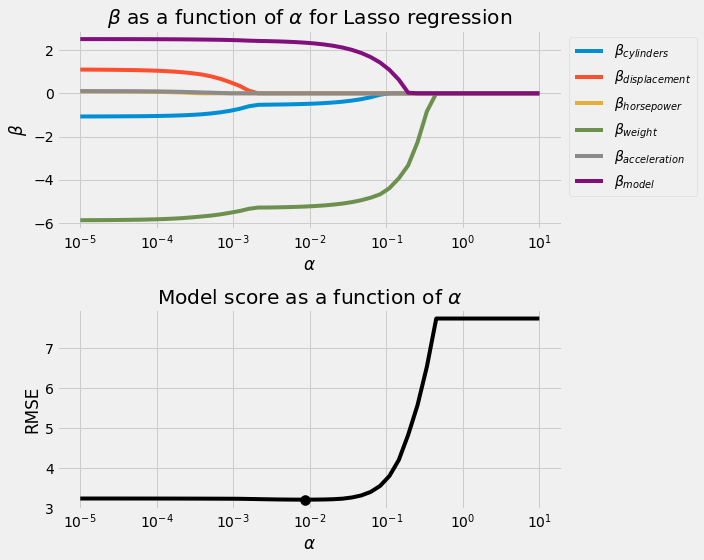

In [24]:
alphas, coefs, scores = get_ridge_lasso_coeff(X_train_s, y_train, -5, 1, reg='Lasso')
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, columns, method='Lasso')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

#### Ridge

The best RMSE is 3.2316340340434815


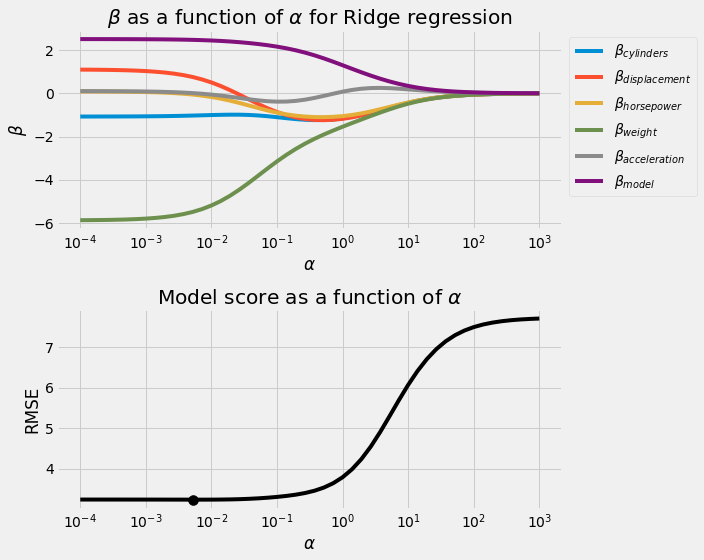

In [25]:
alphas, coefs, scores = get_ridge_lasso_coeff(X_train_s, y_train, -4, 3, reg='Ridge')
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_alpha_v_coef(ax[0], alphas, coefs, columns, method='Ridge')
plot_alpha_v_scores(ax[1], alphas, scores)
fig.tight_layout()

Discussion: what's going on? How does this differ from LASSO?

<br><br><br><br>

### Comparison of Ridge versus Lasso Regression

One of the biggest difference between ridge and lasso regression is that ridge regression can only shrink $\beta$-coefficients asymptotically to 0, while Lasso can shrink $\beta$-coefficients to 0. 

The consequences of this are that Ridge is a good model to select when all variables are somewhat useful, while Lasso is good and eliminating useless variables.  

**Ridge**
- computationally easier because regularization penalty is differentiable
- tends to use several features and force coefficients to be smaller
- $\beta$ asymptotically approaches 0  

**Lasso**
- computationally more difficult because regularization penalty is not differentiable
- good at eliminating useless features, acting as a automatic feature selector

I would avoid default using regularization for feature selection.  Using domain knowledge for feature selection is almost always the best route.  Fine tune your model with regularization after that point. 

## Optional Content


### Elastic net 
Elastic net combines lasso and ridge into one method with two hyper-parameters so that you can get the benefits of both methods! 

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha_{1} \sum_{j=1}^{p} \beta_j^2 + \alpha_{2} \sum_{j=1}^{p} | \beta_j |$$



### Visualizing Loss Functions in Higher Dimensions
To help understand this, consider the contour plots of the loss functions for the RSS, and for the regularization penalty term. Imagine the center of each is the minimum, and we're looking for the minimum of the sum.

In [26]:
def draw_circle(ax, radius, color, x=0, y=0):
    artist = plt.Circle((x, y),
                             radius,
                             color=color,
                             fill=False)
    ax.add_artist(artist)
    return artist
def draw_diamond(ax, radius, color, x=0, y=0):
    artist = plt.Polygon([(x, radius+y),
                               (radius+x, y),
                               (x, -radius+y),
                               (-radius+x, y)],
                              color=color,
                              fill=False)
    ax.add_artist(artist)
    return artist

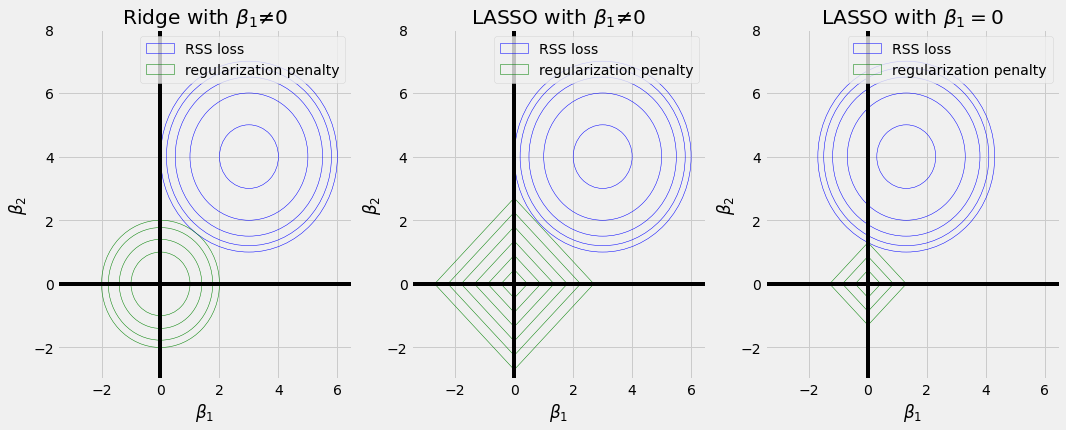

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for ax in axs:
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_xlabel(r"$\beta_1$")
    ax.set_ylabel(r"$\beta_2$")

axs[0].set_title(r"Ridge with $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[0], r, 'b', 3, 4)
for r in [1.0, 1.4, 1.77, 2.0]:
    artist_regularization = draw_circle(axs[0], r, 'g')
axs[0].legend([artist_loss, artist_regularization], ['RSS loss', 'regularization penalty'])

axs[1].set_title(r"LASSO with $\beta_1 \ne 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[1], r, 'b', 3, 4)
for r in [0.45, 0.9, 1.35, 1.8, 2.25, 2.7]:
    artist_regularization = draw_diamond(axs[1], r, 'g')
axs[1].legend([artist_loss, artist_regularization], ['RSS loss', 'regularization penalty'])

# Example with LASSO at zero
axs[2].set_title(r"LASSO with $\beta_1 = 0$")
for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    artist_loss = draw_circle(axs[2], r, 'b', 1.3, 4)
for r in [0.433, 0.866, 1.3]:
    artist_regularization = draw_diamond(axs[2], r, 'g')
axs[2].legend([artist_loss, artist_regularization], ['RSS loss', 'regularization penalty'])

for ax in axs:
    ax.set_xlim(-3.5, 6.5)
    ax.set_ylim(-3, 8)

The minimum of a sum of functions occurs when the gradient of the sum of the functions is zero. This occurs when the gradients of the two functions are equal and opposite, which occurs when the contour lines are parallel.

In the above plots, imagine the minimum solutions are at the points when the outer contours lines are tangent. For Ridge regression, a minimum at $\beta_i = 0$ is very unlikely, but quite possible for LASSO regression.

### Standardizing data 

It is important to standardize your data when using Lasso or Ridge Regression.  

**Question** Why? 

**Review:** 

**Standardization** (in this context) is the process of subtracting the mean from each feature, and then dividing by the standard deviation, so each feature has a mean of 0 and standard deviation of 1.

In linear regression without regularization, scaling **does not matter**. If you change the scale of a feature (multiplying each value by a constant), it will change the corresponding coefficient **but the predictions will be exactly the same**.

This is not true when we add regularization. Since we include a term that is proportional to the $\beta$, the actual predictions will change it we rescale the values.

As a rule of thumb, if changing the units of the features will change the predictions of a model, you need to standardize (or normalize) the values.

Let's standardize data with `sklearn`. 

In [28]:
from sklearn.preprocessing import StandardScaler

X_demo = np.array( [[5,10],
                    [-5,2]] )

# Standardization hard coded
print( (X_demo - np.mean(X_demo, axis=0, keepdims=True) ) /  np.std(X_demo, axis=0, keepdims=True))
# Standardization with Sklearn
print( StandardScaler().fit_transform(X_demo) )

[[ 1.  1.]
 [-1. -1.]]
[[ 1.  1.]
 [-1. -1.]]


Note sklearn has three methods that do similar things...

- `fit`: calculates values needed to transform your data (mean and standard deviation) and stores the values as attributes
- `transform`: standardized your data based on the values calculated in fit
- `fit_transform`: does both a fit and transform on the same data set. 

**Question**

1. Why do we practically have these three different methods? 